In [61]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
matplotlib.rc('image', cmap='Greys')

In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [7]:
#hide
Path.BASE_PATH = path

In [9]:
path.ls()

(#3) [Path('valid'),Path('train'),Path('labels.csv')]

In [10]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [11]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png'),Path('train/3/10093.png'),Path('train/3/10097.png'),Path('train/3/10099.png'),Path('train/3/10116.png'),Path('train/3/10125.png'),Path('train/3/10137.png'),Path('train/3/10141.png'),Path('train/3/10144.png'),Path('train/3/10155.png'),Path('train/3/10161.png')...]

In [95]:
im3_path = threes[10]
im3 = Image.open(im3_path)
im3

In [96]:
array(im3)[5:11, 10:15]

array([[  0,   0,  30, 144, 173],
       [ 12, 148, 244, 254, 253],
       [136, 253, 253, 254, 227],
       [ 94, 231, 231, 169,  41],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0]], dtype=uint8)

Here's the same thing as a PyTorch tensor

In [97]:
tensor(im3)[5:11, 10:15]

tensor([[  0,   0,  30, 144, 173],
        [ 12, 148, 244, 254, 253],
        [136, 253, 253, 254, 227],
        [ 94, 231, 231, 169,  41],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]], dtype=torch.uint8)

In [45]:
#hide_output
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


Baseline - calculate averages

In [48]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

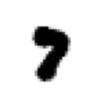

In [62]:
show_image(seven_tensors[30]);

In [55]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [56]:
len(stacked_threes.shape)

3

In [57]:
stacked_threes.ndim

3

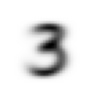

In [63]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

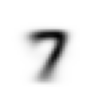

In [64]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

Here is a sample 3

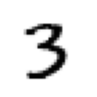

In [65]:
a_3 = stacked_threes[1]
show_image(a_3);

There are two main ways data scientists measure distance in this context:

- Take the mean of the absolute value of differences (absolute value is the function that replaces negative values with positive values). This is called the mean absolute difference or L1 norm
- Take the mean of the square of differences (which makes everything positive) and then take the square root (which undoes the squaring). This is called the root mean squared error (RMSE) or L2 norm.

In [66]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [67]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

Here mse stands for mean squared error, and l1 refers to the standard mathematical jargon for mean absolute value (in math it's called the L1 norm).

In [72]:
#F.l1_loss(a_3.float(),mean3), F.mse_loss(a_3,mean3).sqrt()
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

Use accuracy as the metric for classification models

In [73]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [75]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

In [76]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1200, 0.1333, 0.1127,  ..., 0.1323, 0.1283, 0.1078]),
 torch.Size([1010]))

In [84]:
(valid_3_tens - mean3).shape

torch.Size([1010, 28, 28])

In [85]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [86]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [92]:
is_3(valid_3_tens)

tensor([ True,  True,  True,  ..., False,  True,  True])

In [91]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))